In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/kds/1sem/ditw/ditw_project')

In [3]:
!pip install sentence_transformers
!pip install hdbscan
!pip install umap-learn
!pip install matplotlib
!pip install pandas

     |████████████████████████████████| 78 kB 2.9 MB/s 
     |████████████████████████████████| 3.4 MB 25.8 MB/s 
     |████████████████████████████████| 3.3 MB 38.4 MB/s 
     |████████████████████████████████| 1.2 MB 49.9 MB/s 
     |████████████████████████████████| 61 kB 475 kB/s 
     |████████████████████████████████| 895 kB 47.2 MB/s 
     |████████████████████████████████| 596 kB 49.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=bd6b1c4865feb28fe9d261308fd1f1a1e890d89d59d8363462661e001ecc6c21
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 6.4 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements

In [4]:
from src.json_utils import read_json, read_jsonl
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import pandas as pd
from src.preprocessing import *
from sklearn.cluster import DBSCAN
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
df = pd.read_csv('data/folketinget_data_latest.csv')
df["sagstrin_sag_titel"] = df[["sagstrin_sag_titel", "konklusion", "sagstrin_sag_titelkort"]].astype(str)

In [12]:
os.listdir()
full = pd.read_csv('data/folketinget_data.csv')
full["sagstrin_sag_titel"] = full[["sagstrin_sag_titel", "sagstrin_sag_titelkort"]].astype(str)
full.head()

,Unnamed: 0,id,nummer,konklusion,vedtaget,kommentar,mødeid,typeid,sagstrinid,opdateringsdato,møde_titel,møde_status,møde_type,møde_periode_startdato,møde_periode_slutdato,møde_periode_type,type,sagstrin_titel,sagstrin_status,sagstrin_type,sagstrin_sag_type,sagstrin_sag_kategori,sagstrin_sag_status,sagstrin_sag_titel,sagstrin_sag_titelkort,sagstrin_periode_start,sagstrin_periode_slut,sagstrin_periode_type,merged
0,0,1,411,"Vedtaget\n\n108 stemmer for forslaget (V, S, D...",True,NaN,17,2,NaN,2014-09-09T09:05:59.653,Møde i salen,Afholdt,Møde i salen,2013-10-01T12:00:00,2014-10-01T12:00:00,samling,Udvalgsindstilling,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,2021-10-05T12:00:00,2022-10-04T12:00:00,samling,"Vedtaget\n\n108 stemmer for forslaget (V, S, D..."
1,1,2,412,"Vedtaget\n\n98 stemmer for forslaget (V, S, DF...",True,NaN,18,1,4849.0,2014-09-09T09:25:05.717,Møde i salen,Afholdt,Møde i salen,2013-10-01T12:00:00,2014-10-01T12:00:00,samling,Endelig vedtagelse,3. behandling,Behandlet/Vedtaget,[17 '3. behandling' '2015-04-17T11:36:50.753'],Lovforslag,[13 'Regeringsforslag' '2015-05-27T13:49:30.737'],Stadfæstet,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,2013-10-01T12:00:00,2014-10-01T12:00:00,samling,"Vedtaget\n\n98 stemmer for forslaget (V, S, DF..."
2,2,3,1,"Vedtaget\n\n59 stemmer for forslaget (S, RV, S...",True,NaN,41,3,17351.0,2018-01-24T16:46:33.99,Møde i salen,Dagsorden låst,Møde i salen,2012-10-02T00:00:00,2013-10-01T00:00:00,samling,Forslag til vedtagelse,Behandling,Behandlet,[10 'Behandling' '2014-10-07T14:16:46.733'],Forslag til vedtagelse,NaN,Vedtaget,"Folketinget konstaterer, at Danmark stod dårli...",Om rigets tilstand.,2012-10-02T00:00:00,2013-10-01T00:00:00,samling,"Vedtaget\n\n59 stemmer for forslaget (S, RV, S..."
3,3,4,7,"Vedtaget\n\n72 stemmer for forslaget (S, DF, R...",True,NaN,156,1,18370.0,2018-01-25T10:25:25.64,Møde i salen,Dagsorden låst,Møde i salen,2012-10-02T00:00:00,2013-10-01T00:00:00,samling,Endelig vedtagelse,3. behandling,Behandlet/Vedtaget,[17 '3. behandling' '2015-04-17T11:36:50.753'],Lovforslag,[13 'Regeringsforslag' '2015-05-27T13:49:30.737'],Stadfæstet,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,2012-10-02T00:00:00,2013-10-01T00:00:00,samling,"Vedtaget\n\n72 stemmer for forslaget (S, DF, R..."
4,4,5,412,"Vedtaget\n\n98 stemmer for forslaget (V, S, DF...",True,NaN,18,1,4849.0,2017-08-10T12:57:52.27,Møde i salen,Afholdt,Møde i salen,2013-10-01T12:00:00,2014-10-01T12:00:00,samling,Endelig vedtagelse,3. behandling,Behandlet/Vedtaget,[17 '3. behandling' '2015-04-17T11:36:50.753'],Lovforslag,[13 'Regeringsforslag' '2015-05-27T13:49:30.737'],Stadfæstet,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,2013-10-01T12:00:00,2014-10-01T12:00:00,samling,"Vedtaget\n\n98 stemmer for forslaget (V, S, DF..."


In [6]:
df['merged'] = df['sagstrin_sag_titel']+ ' ' +df['sagstrin_sag_titelkort']
df = df[df['merged'].notnull()]
text_without_processing = list(df['merged'].values)
len(text_without_processing)

1663

In [13]:
full['merged'] = full['sagstrin_sag_titel']+ ' ' +full['sagstrin_sag_titelkort']
full = full[full['merged'].notnull()]
text_without_processing = list(full['merged'].values)
len(text_without_processing)
from nltk.tokenize import word_tokenize
tokenized = [word_tokenize(i) for i in text_without_processing]
flat_list = [item for sublist in tokenized for item in sublist]
len(set(flat_list))

19052

In [8]:
from nltk.tokenize import word_tokenize
tokenized = [word_tokenize(i) for i in text_without_processing]
flat_list = [item for sublist in tokenized for item in sublist]
len(set(flat_list))

7739

In [ ]:
encoder = SentenceTransformer('Maltehb/danish-bert-botxo')
embeddings = encoder.encode(text_without_processing, show_progress_bar=True, normalize_embeddings = False)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/Maltehb_danish-bert-botxo were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=10, 
                            metric='cosine', random_state=42).fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.5).fit(umap_embeddings)

In [ ]:
print(Counter(cluster.labels_))

Counter({17: 286, -1: 254, 20: 213, 14: 197, 4: 192, 0: 54, 1: 53, 13: 50, 2: 49, 16: 46, 11: 35, 21: 33, 19: 32, 15: 27, 22: 23, 10: 16, 8: 15, 3: 15, 18: 14, 5: 14, 7: 12, 6: 11, 9: 11, 12: 11})


In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
from pylab import *
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.patches as patches
from __future__ import unicode_literals
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


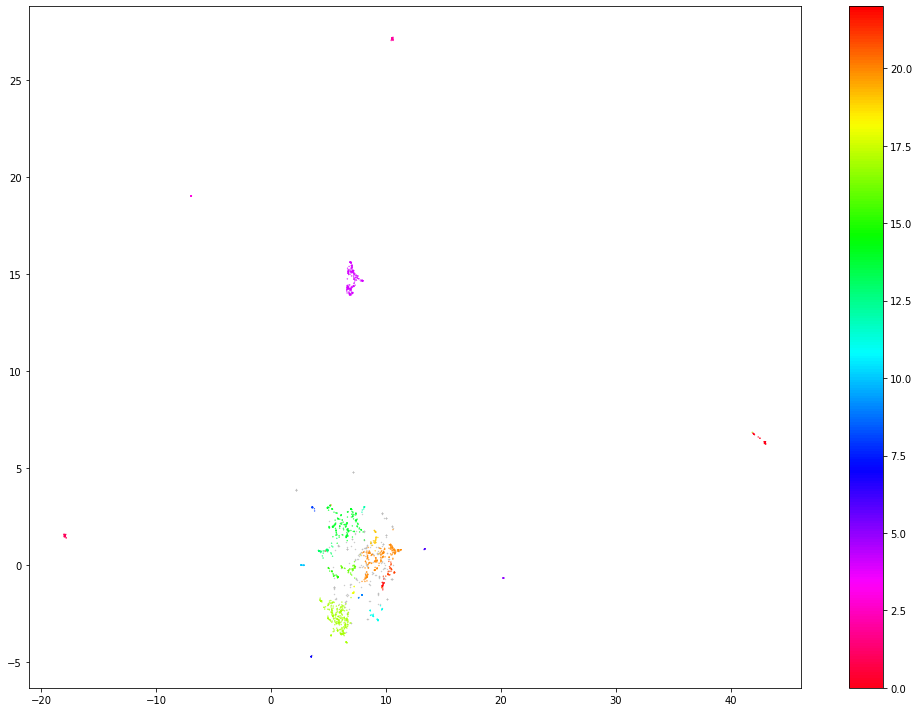

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(14, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.15, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

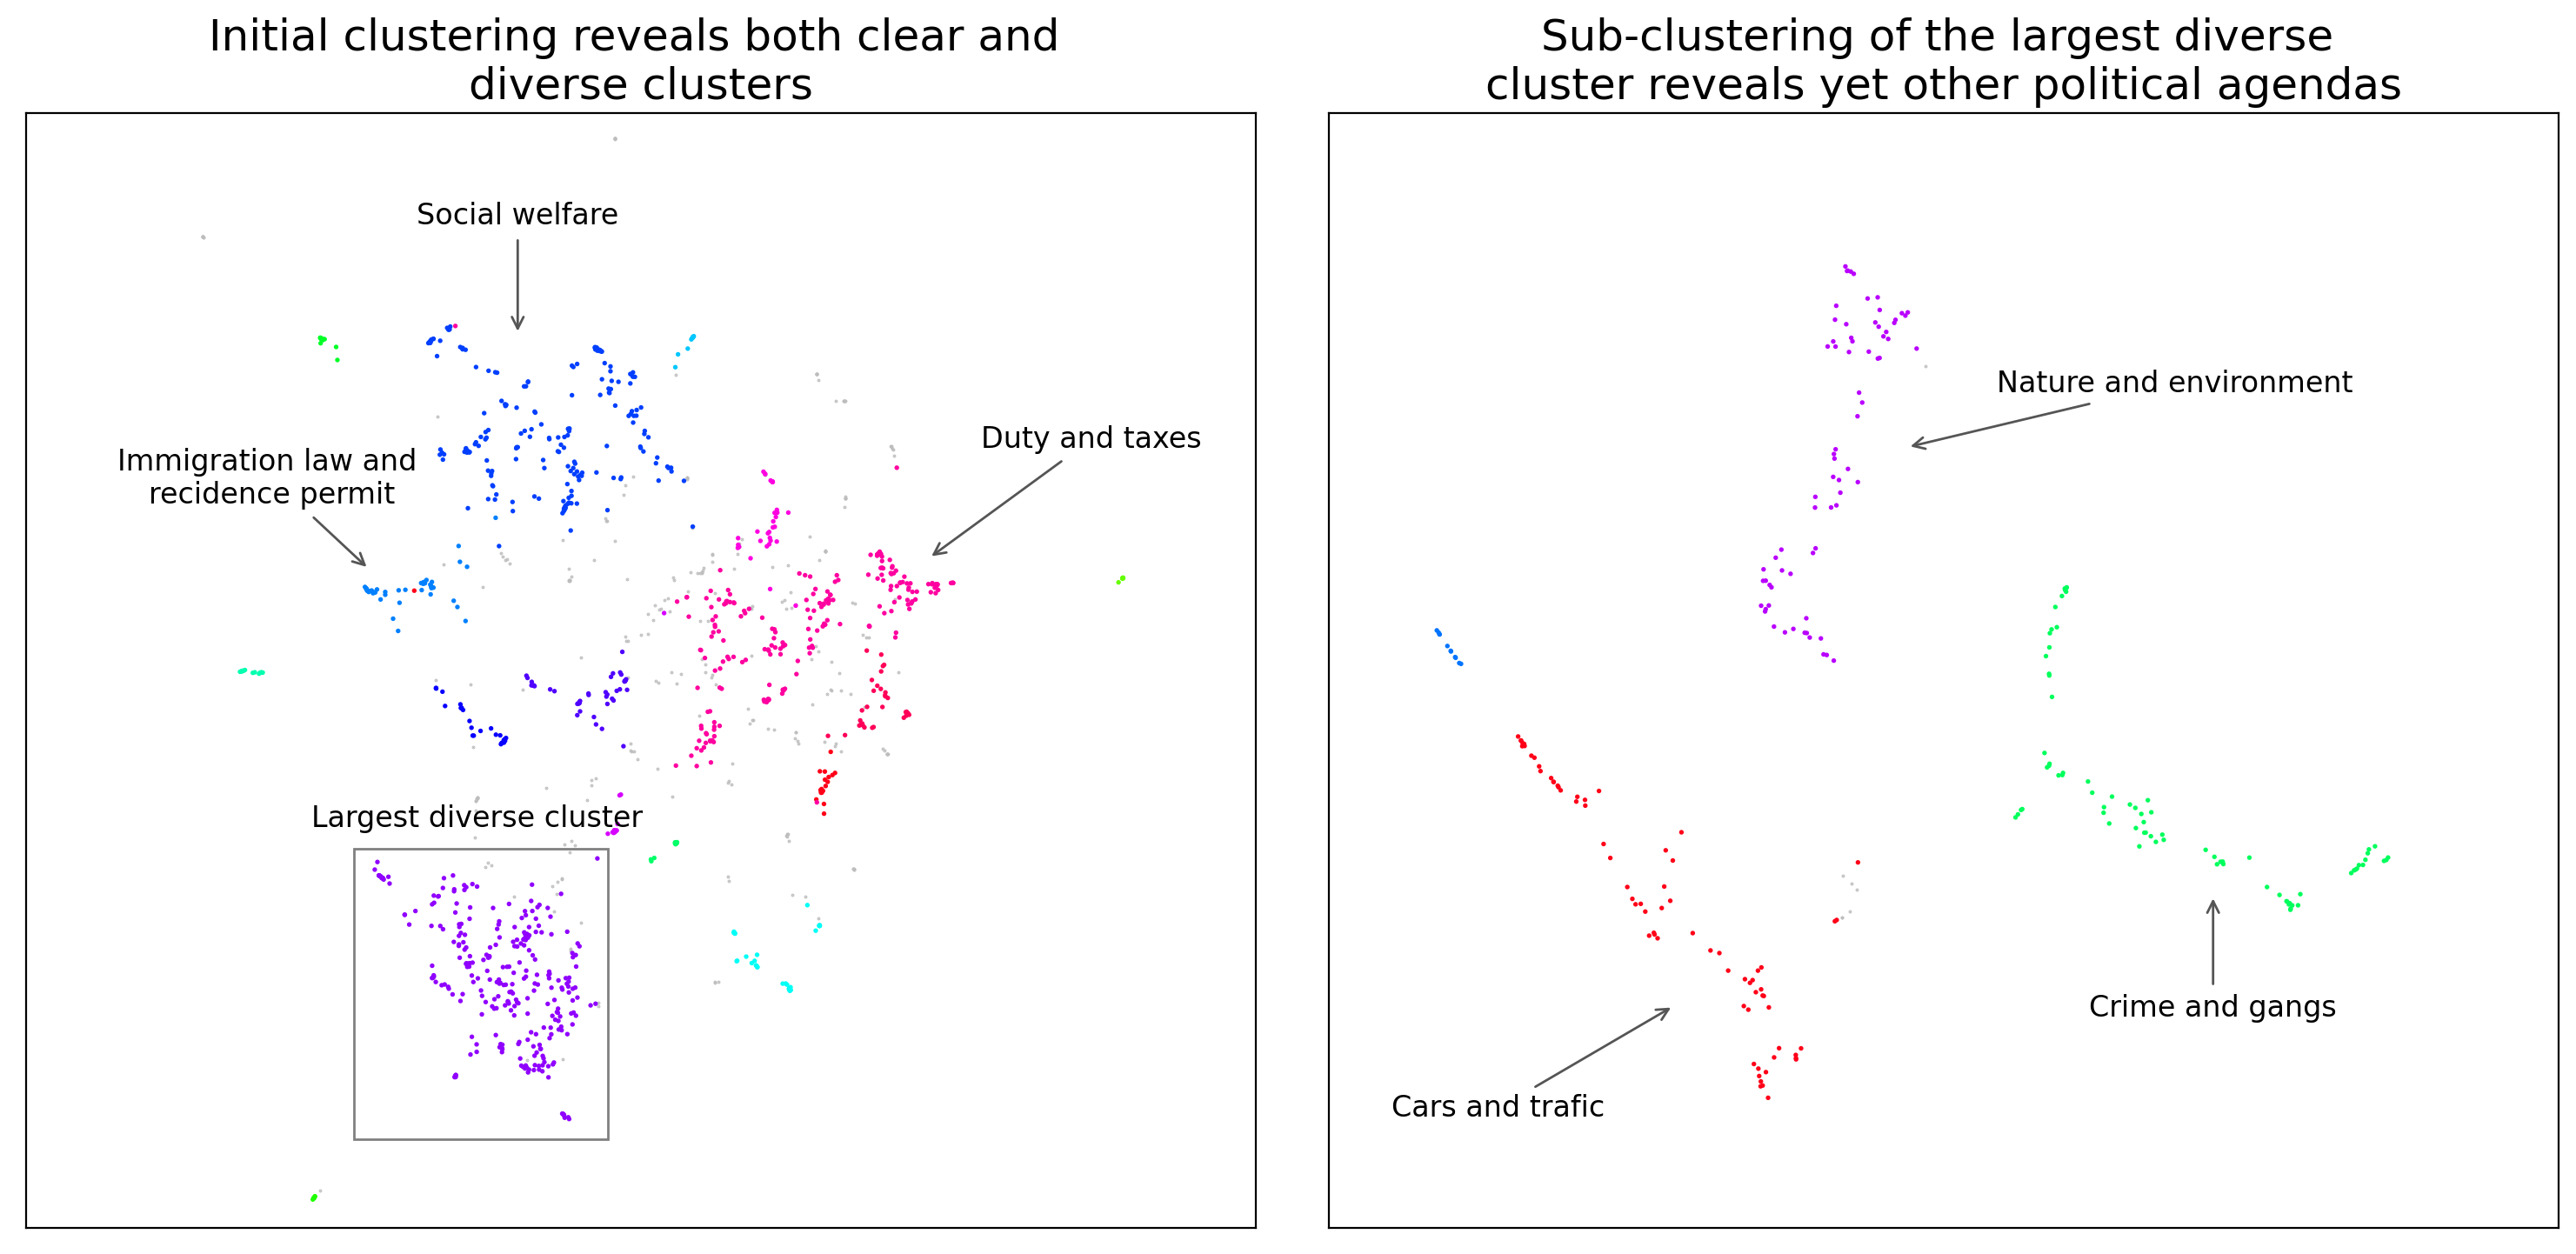

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7.5), dpi = 200)

# Large Clusters
ax1.set_title('Initial clustering reveals both clear and \ndiverse clusters', fontsize=18)
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
ax1.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
ax1.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.85, cmap='hsv')

# Adding rectangle
rect = patches.Rectangle((4, -4.2), 3.1, 2.6, linewidth=1, edgecolor='grey', facecolor='none')
ax1.add_patch(rect)
ax1.text(5.5, -1.4, 'Largest diverse cluster', ha='center', fontsize=12)

# Annotate cluster
ax1.annotate('Duty and taxes', (11,1), (13,2), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)
ax1.annotate('Social welfare', (6,3), (6,4), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)
ax1.annotate('Immigration law and \nrecidence permit', (4.2,0.9), (3.0,1.5), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)

# Adding axis
ax1.axis(xmin=0,xmax=15, ymin=-5, ymax =5)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)

# Sub clusters
# Visualize clusters
sub_outliers = large_result.loc[large_result.labels == -1, :]
sub_clustered = large_result.loc[large_result.labels != -1, :]
ax2.scatter(sub_outliers.x, sub_outliers.y, color='#BDBDBD', s=0.15)
ax2.scatter(sub_clustered.x, sub_clustered.y, c=sub_clustered.labels, s=0.85, cmap='hsv')
ax2.set_title('Sub-clustering of the largest diverse \ncluster reveals yet other political agendas', fontsize=18)

# Adding axis
ax2.axis(xmin=-4,xmax=12, ymin=6, ymax =16)
#ax2.axes.xaxis.set_visible(False)
#ax2.axes.yaxis.set_visible(False)

# Annotate cluster
ax2.annotate('Crime and gangs', (7.5,9), (7.5,7.9), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)
ax2.annotate('Nature and environment', (3.5,13), (7,13.5), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)
ax2.annotate('Cars and trafic', (0.5,8), (-1.8,7), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)

plt.tight_layout()
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)

plt.savefig('folketingett_clustering.png', dpi=300)

In [ ]:
from nltk.tokenize import word_tokenize

with open('data/danish_stopwords.txt') as stop_file:
  stopwords = [word.strip() for word in stop_file.readlines()]

def remove_stopwords(token: str) -> str:
    return token if token not in stopwords else ''

def remove_newlines(text: str) -> str:
    return re.sub(r'\n+', ' ', text)

def remove_numbers(text, str) -> str:
    return re.sub(r'\d+', '', text)


def normalize_spaces(text: str) -> str:
    return re.sub(r'\s{2,}', ' ', text)

import string 
    
def remove_punctuation(text: str) -> str:
    """BUT DO NOT REMOVE HASHTAGS OR MENTIONS"""
    regexp = re.compile(r'([#@]\w+)')
    return text if regexp.search(text) else re.sub(f'[{string.punctuation}]', '', text)


def is_website_token(token: str) -> str:
    if token[:4] == 'http':
        return ''
    else:
        return token

def remove_standalone_numbers(text: str) -> str:
    return re.sub(f'(?<!\S)\d+(?!\S)', '', text)

def split_by_space(text: str) -> List[str]:
    return text.split(' ')


def save_json(path, container) -> None:
    """write dict to path."""
    print(f"Saving json to {path}")
    with open(path, "w") as outfile:
        json.dump(container, outfile)

In [ ]:
text_list = text_without_processing

tokenized_text = [[token for token in word_tokenize(i)] for i in text_list]

print(tokenized_text[:2])

preprocessing_func = [remove_punctuation, str.lower, is_website_token, remove_stopwords, remove_standalone_numbers]

all_tokenizer_text = []

for token_text in tokenized_text:
    post_processed = []
    for token in token_text:
        for function in preprocessing_func:
            token = function(token)
        if token != '':
            post_processed.append(token)
    all_tokenizer_text.append(' '.join(post_processed))

print(all_tokenizer_text[:2])
print(len(all_tokenizer_text))

[['Det', 'går', 'økonomisk', 'bedre', 'end', 'længe', '.', 'Siden', '2015', 'er', 'der', 'truffet', 'mange', 'beslutninger', ',', 'som', 'trækker', 'Danmark', 'i', 'den', 'rigtige', 'retning', '.', 'Flere', 'er', 'i', 'privat', 'beskæftigelse', ',', 'og', 'færre', 'er', 'på', 'passiv', 'offentlig', 'forsørgelse', '.', 'Der', 'er', 'positiv', 'udvikling', 'i', 'alle', 'landsdele', ',', 'men', 'der', 'skal', 'fortsat', 'tages', 'initiativer', 'for', 'at', 'sikre', 'et', 'Danmark', 'i', 'bedre', 'balance', '.', 'Vi', 'er', 'optaget', 'af', 'at', 'sikre', 'et', 'bedre', 'klima', 'og', 'miljø', 'for', 'de', 'kommende', 'generationer', '.', 'Der', 'er', 'gennemført', 'helt', 'nødvendige', 'stramninger', 'af', 'udlændingepolitikken', '.', 'Retningen', 'skal', 'fastholdes', ',', 'så', 'asyltallet', 'fortsat', 'holdes', 'på', 'et', 'meget', 'lavt', 'niveau', '.', 'Samtidig', 'skal', 'praksis', 'ændres', ',', 'så', 'midlertidigt', 'ophold', 'også', 'reelt', 'bliver', 'midlertidigt', '.', 'Det', 

In [ ]:
print(len(all_tokenizer_text))
print(len(text_without_processing))

1663
1663


In [ ]:
docs_df = pd.DataFrame(all_tokenizer_text , columns=["Doc"])
docs_df['Original Docs'] = text_without_processing
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

#### Group by topic and select a sample

In [ ]:
#docs_df.groupby(['Topic']).filter(lambda group: len(group) > 20).groupby(['Topic']).sample(15).to_json('data/folketinget_large_clusters.json')

### Tf-idf on docs from each cluster

In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 3)):
    count = CountVectorizer(tokenizer = split_by_space, stop_words = None, ngram_range = (1,1)).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
18,17,286
0,-1,254
21,20,213
15,14,197
5,4,192
1,0,54
2,1,53
14,13,50
3,2,49
17,16,46


In [ ]:
top_n_words[13]
#import json
#save_json('data/folketinget_top_n_words_large_cluster.json', top_n_words)

[('udlændingeloven', 0.05721514154846901),
 ('opholdstilladelser', 0.05710697296549425),
 ('inddragelse', 0.055362731262126035),
 ('overtrædelse', 0.05289077480821202),
 ('flygtninge', 0.05115469058174602),
 ('repatrieringsloven', 0.04717928635511179),
 ('indrejseforbud', 0.04294460228799646),
 ('antallet', 0.041423736210617235),
 ('indfødsret', 0.040306310731008196),
 ('integrationsloven', 0.03872693783675275),
 ('underretnings', 0.037110256793896096),
 ('meldepligt', 0.037110256793896096),
 ('opholds', 0.035787168573330384),
 ('fremmedkrigere', 0.03520630712432069),
 ('ydelsesnedsættelse', 0.034087362203708546),
 ('familiesammenføringer', 0.034087362203708546),
 ('dansk', 0.033599016741087125),
 ('forsørgere', 0.03220845171599735),
 ('repatriering', 0.03098366872286265),
 ('udenrigstjenesten', 0.03098366872286265),
 ('videre', 0.02993358941671292),
 ('loft', 0.029560276118774213),
 ('valg', 0.028899791543597834),
 ('udlændinge', 0.028785236124989403),
 ('europaparlamentet', 0.0286297

In [ ]:
# Get topic ids of alle clusters with more than 200 documents
#topic_subset = topic_sizes[topic_sizes.Doc > 100]
#topic_subset = list(topic_subset.Topic.values)

In [ ]:
#print(topic_subset)
#len(top_n_words)
#print(topic_sizes.head(20))
#print(top_n_words.keys())

### Reduce large clusters

In [ ]:
# Reduce large clusters

# Get large cluster idx
large_cluster_idx = [idx for idx, label in enumerate(cluster.labels_) if label == 17]
large_cluster_embeddings = umap_embeddings[large_cluster_idx,:]

In [ ]:
# Reduce dim
large_umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(large_cluster_embeddings)


large_cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.5).fit(large_umap_embeddings)

print(Counter(large_cluster.labels_))

# Prepare data
large_umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(large_cluster_embeddings)
large_result = pd.DataFrame(large_umap_data, columns=['x', 'y'])
large_result['labels'] = large_cluster.labels_

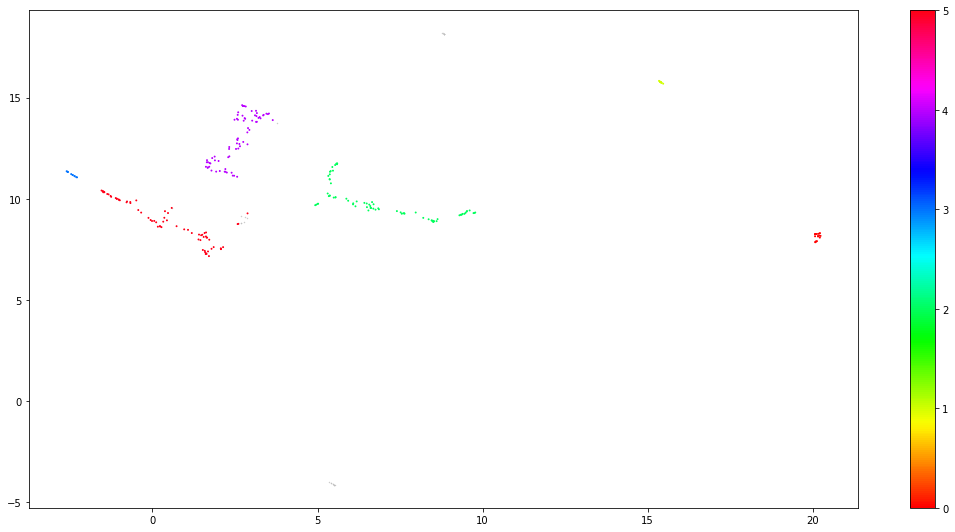

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 7.5))
sub_outliers = large_result.loc[large_result.labels == -1, :]
sub_clustered = large_result.loc[large_result.labels != -1, :]
plt.scatter(sub_outliers.x, sub_outliers.y, color='#BDBDBD', s=0.15)
plt.scatter(sub_clustered.x, sub_clustered.y, c=sub_clustered.labels, s=0.85, cmap='hsv')
plt.colorbar()
plt.tight_layout()

In [ ]:
docs_df = pd.DataFrame([all_tokenizer_text[i] for i in large_cluster_idx] , columns=["Doc"])
docs_df['Original Docs'] = [text_without_processing[i] for i in large_cluster_idx]
docs_df['Topic'] = large_cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
#docs_df.groupby(['Topic']).filter(lambda group: len(group) > 20).groupby(['Topic']).sample(15).to_json('data/folketing_small_subclusters.json')

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df))

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
3,2,77
5,4,72
6,5,72
0,-1,25
1,0,18
2,1,11
4,3,11


In [ ]:
top_n_words[3]

[('mærkning', 0.4017585007117766),
 ('kød', 0.3522479878146376),
 ('minkavl', 0.2871468627653827),
 ('slagtemetode', 0.2871468627653827),
 ('folketingsbeslutning', 0.2385516439940711),
 ('forslag', 0.2319077071076975),
 ('krav', 0.22113284556919743),
 ('forbud', 0.20596838218260055),
 ('undersøgelse', 0.16007693568173767),
 ('registrering', 0.16007693568173767),
 ('lange', 0.16007693568173767),
 ('katte', 0.16007693568173767),
 ('bornholm', 0.16007693568173767),
 ('færgebetjening', 0.16007693568173767),
 ('flagning', 0.16007693568173767),
 ('dyretransporter', 0.16007693568173767),
 ('drøvtyggere', 0.16007693568173767),
 ('disciplinærstraf', 0.16007693568173767),
 ('afgift', 0.16007693568173767),
 ('børnetolke', 0.16007693568173767),
 ('afviklingen', 0.16007693568173767),
 ('anvendelse', 0.14357343138269135),
 ('folketinget', 0.13391950023725885),
 ('indføre', 0.10776206479278005),
 ('dansk', 0.08874997678759503),
 ('forhold', 0.0),
 ('generationsskifte', 0.0),
 ('forbehold', 0.0),
 ('g

In [ ]:
#save_json('data/folketinget_top_n_words_small_subcluster.json', top_n_words)

Saving json to data/folketinget_top_n_words_small_subcluster.json
